# Matching tracked Cellpose data with Suite2p

The point of this notebook is to take the subset of 'good' GAD cells (the ones tracked by t2p based on Cellpose) and compare them to the (non-tracked) Suite2p output to determine if the cells express GCamp (are active) on at least N days.

## More detailed instructions:
From [move_deve_TODO](https://docs.google.com/document/d/1kJZNt8DOrAlpemqNQHvNtgc_-E6N5xySpVgJw6PGQSM/edit)

- Erode each mask a bit maybe to avoid too much overlap / neuropil contamination (optional, todo later, would need to recalculate traces)
- For each session individually see if interneurons are also detected by suite2p… For each session:
    - Take tracked Cellpose masks and suite2p masks (p_cell = 0 or very low)
    - Find matches same as in track2p (compute e. g. IoU and then solve assignment problem) + threshold somehow the false matches (probably again bimodal histogram)
    - Also in the meantime (as a validation) make composite visualisations of mean red / mean green + maybe also of ‘correlation map’ as pseudochannel (blue) (these visualisations would also be useful in the publication figure 1)
    - This gives boolean vector of 0 and 1 if interneuron is ‘active’ on that day 
    - Now across sessions concatenate this vector to a matrix of days/neurons saying which neuron is active on which day
    - For spontaneous and movement analysis only use neurons active on at least N number of days (see the statistics of this)
    - Also use this to exclude interneurons from the suite2p output !!! (for example for a more fair comparison of movement encoding)


In [1]:
import os
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt

# import linear sum assignment 
from scipy.optimize import linear_sum_assignment

from skimage.filters import threshold_otsu, threshold_minimum

from cellpose_track2p.io import get_s2p_t2p_alldays, load_all_ds_stat_iscell
from cellpose_track2p.plot import roi_to_img_2ch, plot_iou_dist, plot_all_roi_overlay

from track2p.io.loaders import get_all_roi_array_from_stat
from track2p.io.s2p_loaders import load_all_ds_mean_img
from track2p.match.utils import get_cost_mat, get_iou 


# refresh the librrary using line magic
%load_ext autoreload
%autoreload 2

In [2]:
t2p_cp_save_path = 'data_proc/jm/jm038_gad/track2p'
plane = 'plane0'                                    # which plane to process (the example dataset is single-plane)
iscell_thr = 0                                      # for now use 0 but can put a little threshold to remove the really bad crap 
thr_type = 'otsu'                                   # thresholding method to use 'otsu' or 'min'

In [3]:
track_ops_cp = np.load(os.path.join(t2p_cp_save_path, 'track_ops.npy'), allow_pickle=True).item()
track_ops_cp = SimpleNamespace(**track_ops_cp)

In [4]:
all_stat_t2p_cp, all_f_t2p_cp, all_f_neu_t2p_cp, all_spks_t2p_cp, all_ops_cp = get_s2p_t2p_alldays(t2p_cp_save_path, track_ops_cp.all_ds_path, track_ops_cp.iscell_thr)

Datasets used for t2p:
/Users/jure/Documents/cossart_lab/data/jm/jm038_gad/2023-05-06_a
/Users/jure/Documents/cossart_lab/data/jm/jm038_gad/2023-05-05_a
/Users/jure/Documents/cossart_lab/data/jm/jm038_gad/2023-05-04_a
/Users/jure/Documents/cossart_lab/data/jm/jm038_gad/2023-05-03_a
/Users/jure/Documents/cossart_lab/data/jm/jm038_gad/2023-05-02_a
/Users/jure/Documents/cossart_lab/data/jm/jm038_gad/2023-05-01_a
/Users/jure/Documents/cossart_lab/data/jm/jm038_gad/2023-04-30_a

Number of cells matched across all days: 34
Number of days: 7


In [5]:
# load the masks of suite2p

all_ds_path_s2p = np.copy(track_ops_cp.all_ds_path)
# now in each string of this list remove the _gad substring
all_ds_path_s2p = [x.replace('_gad', '') for x in all_ds_path_s2p]

all_stat_s2p = load_all_ds_stat_iscell(all_ds_path_s2p, iscell_thr=0)


In [7]:
# make an intersection plot

i = 0 # day index

stat_t2p_cp = all_stat_t2p_cp[i]
stat_s2p = all_stat_s2p[i][0]                                           # second index is for plane - here there is anyways only one plane

roi_t2p_cp = get_all_roi_array_from_stat(stat_t2p_cp, track_ops_cp)     # here track_ops_cp is only used for the FOV size (same between the two)
roi_s2p = get_all_roi_array_from_stat(stat_s2p, track_ops_cp)


In [9]:
# now do the assignemnt of the rois as in track2p
track_ops_cp.matching_method = 'iou'
track_ops_cp.iou_dist_thr = 16 # maybe change this

# 1) compute cost matrix (currently two methods available, see DefaultTrackOps)
cost_mat, all_inds_ref_filt, all_inds_reg_filt = get_cost_mat(roi_t2p_cp, roi_s2p, track_ops_cp) 

cost_mat computed with method: iou
cost_mat shape: (34, 3145)
cost_mat min: 0.3977272727272727
cost_mat max: 1.0


In [10]:
# 2) optimally assign pairs
ref_ind_filt, reg_ind_filt = linear_sum_assignment(cost_mat)

In [11]:
# 3) now index only the matched rois
roi_t2p_cp_matched = roi_t2p_cp[:, :, ref_ind_filt]
roi_s2p_matched = roi_s2p[:, :, reg_ind_filt]

In [12]:
# 4) for each matched pair (len(all_roi_ref)) compute thresholding metric (in this case IOU, the filtering will be done afterwards in the all-day assignment)
thr_met = get_iou(roi_t2p_cp_matched, roi_s2p_matched)

thr_otsu = threshold_otsu(thr_met)
thr_min = threshold_minimum(thr_met)


In [13]:
# now get the final matches and plot them overlayed over all
# filter out the pairs that are below the threshold
thr = thr_otsu if thr_type == 'otsu' else thr_min
thr_inds = np.where(thr_met > thr)[0]

roi_t2p_cp_matched_thr = roi_t2p_cp_matched[:, :, thr_inds]
roi_s2p_matched_thr = roi_s2p_matched[:, :, thr_inds]

# TODO: almost done... just figure out a way to output these results

In [14]:
# compute images for plotting
roi_image_both = roi_to_img_2ch(roi_t2p_cp, roi_s2p, rgb_ch1=0, rgb_ch2=1)
roi_image_both_matched = roi_to_img_2ch(roi_t2p_cp_matched, roi_s2p_matched, rgb_ch1=0, rgb_ch2=1)
roi_image_both_matched_thr = roi_to_img_2ch(roi_t2p_cp_matched_thr, roi_s2p_matched_thr, rgb_ch1=0, rgb_ch2=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


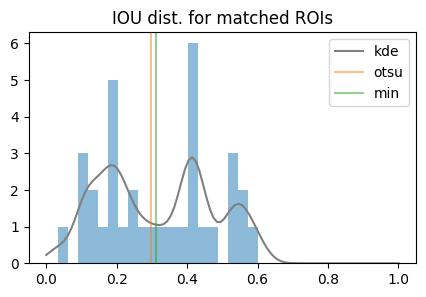

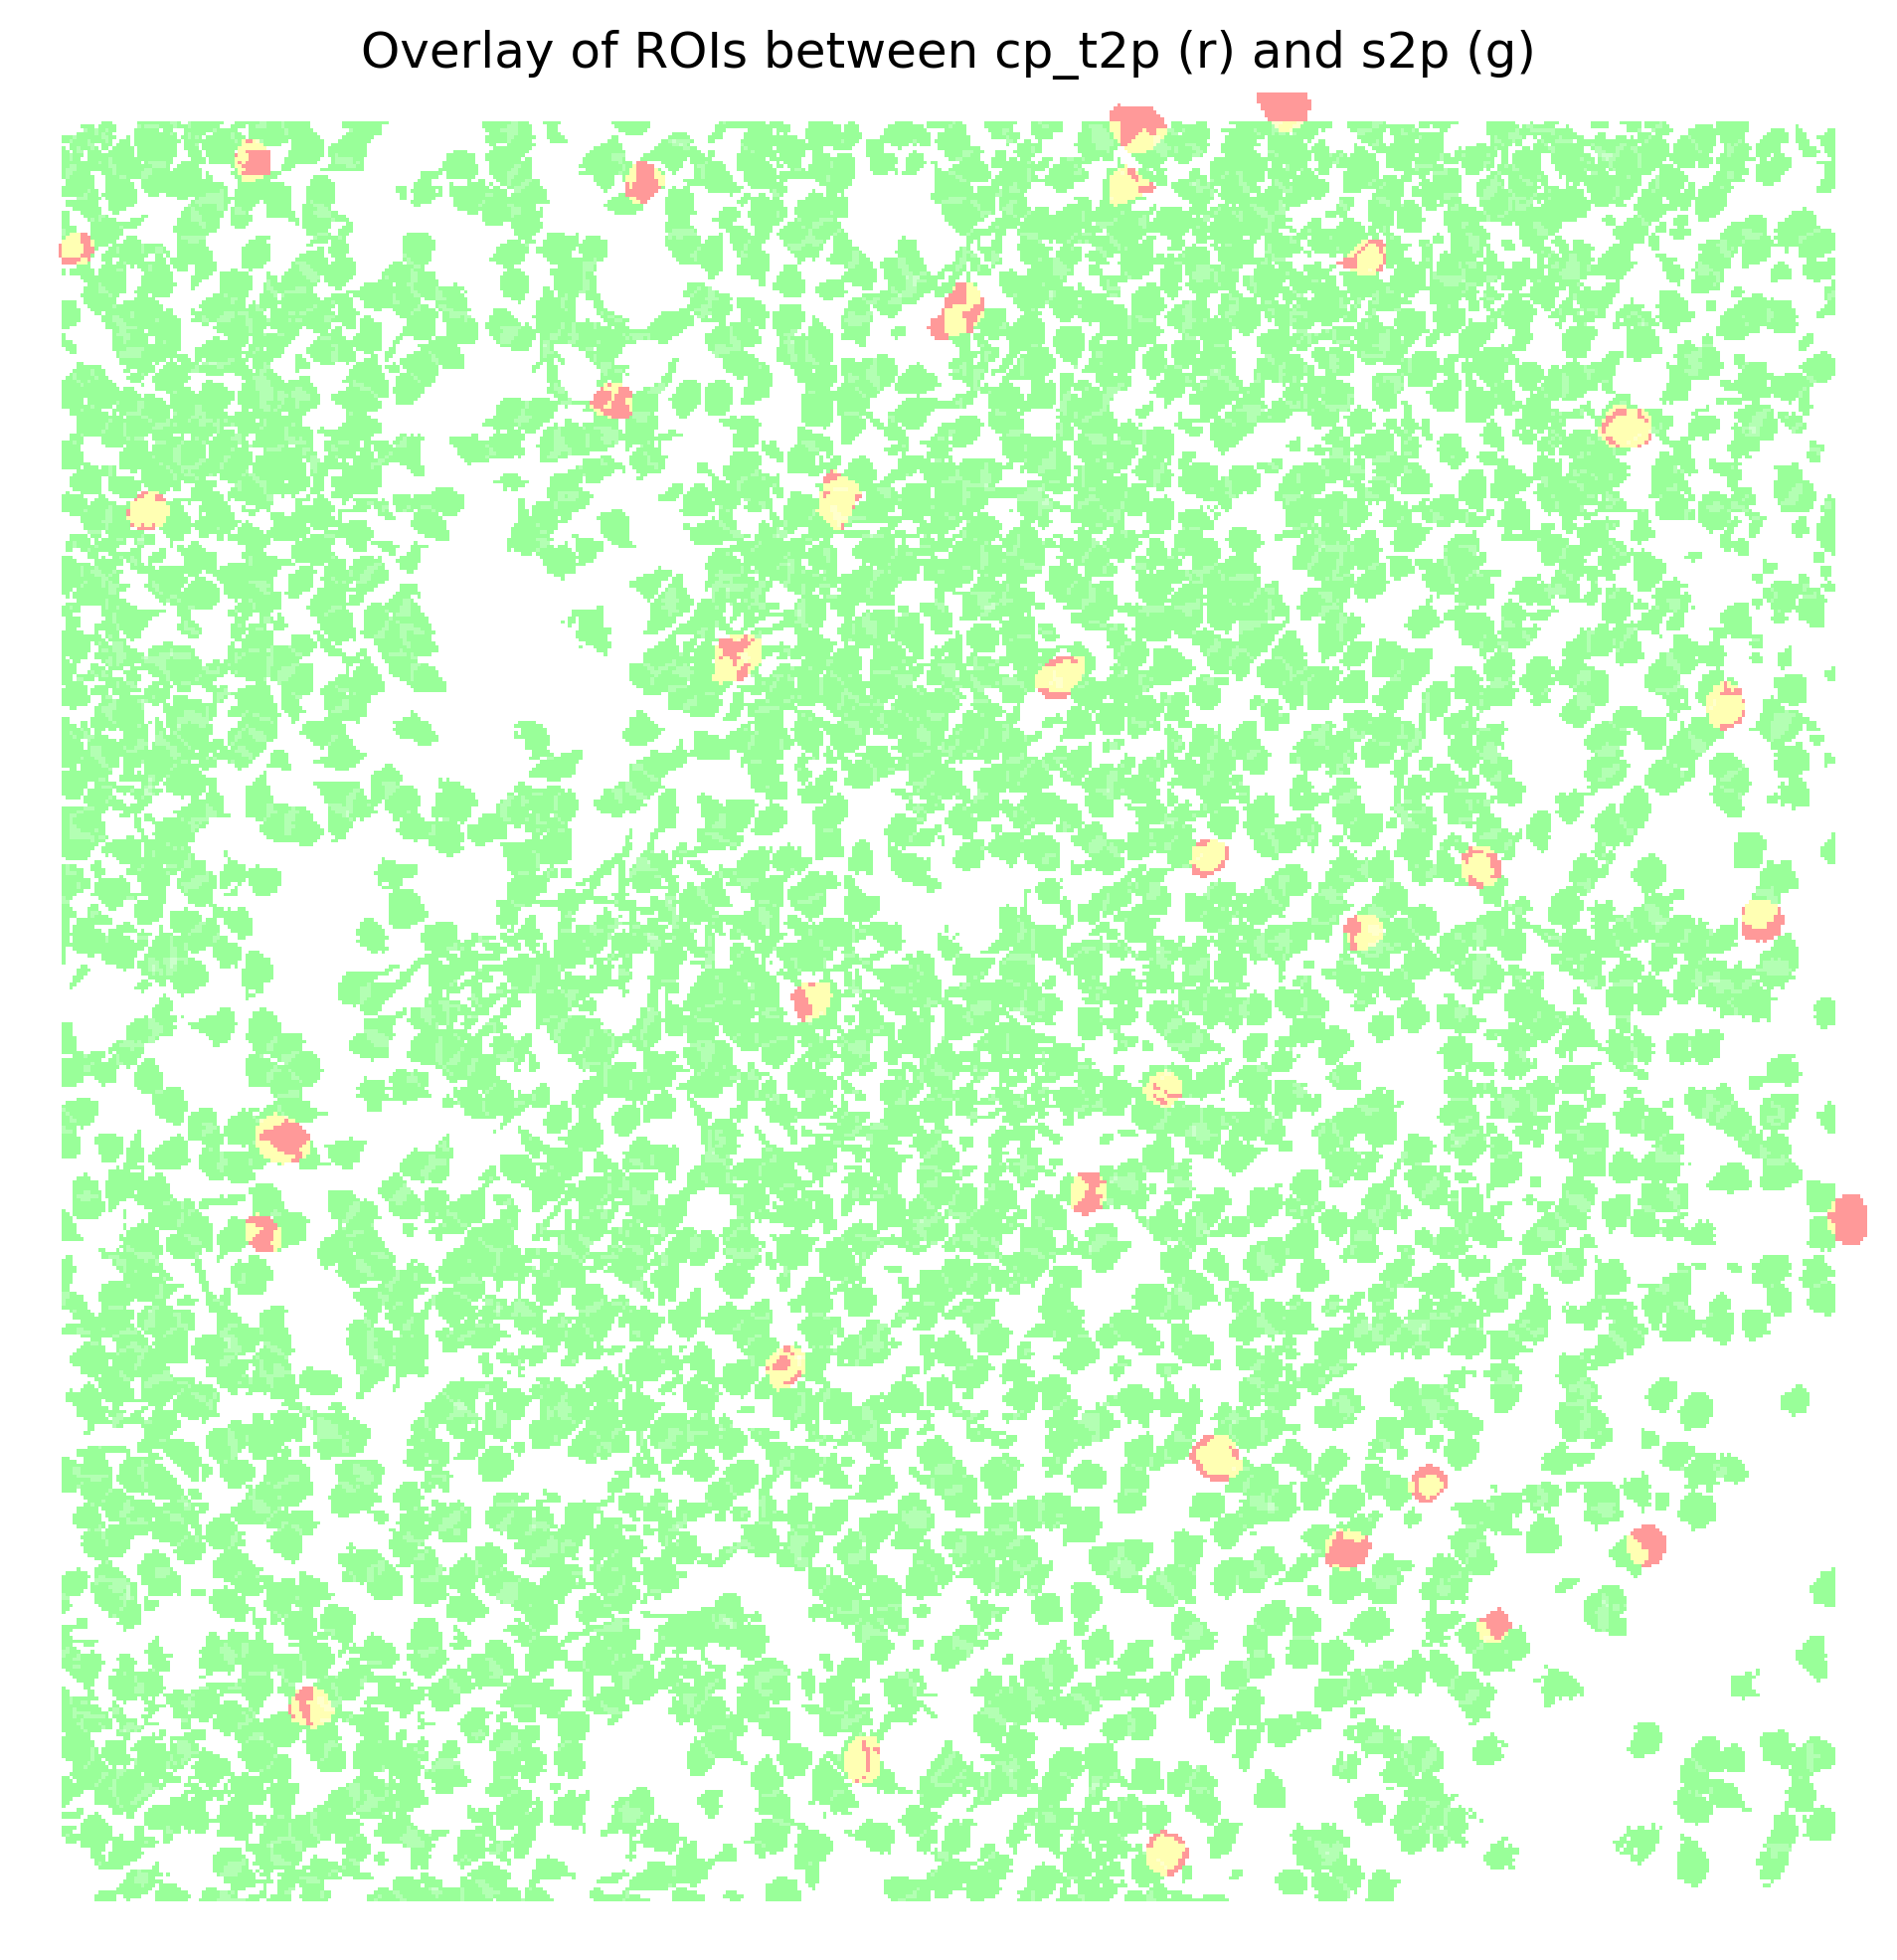

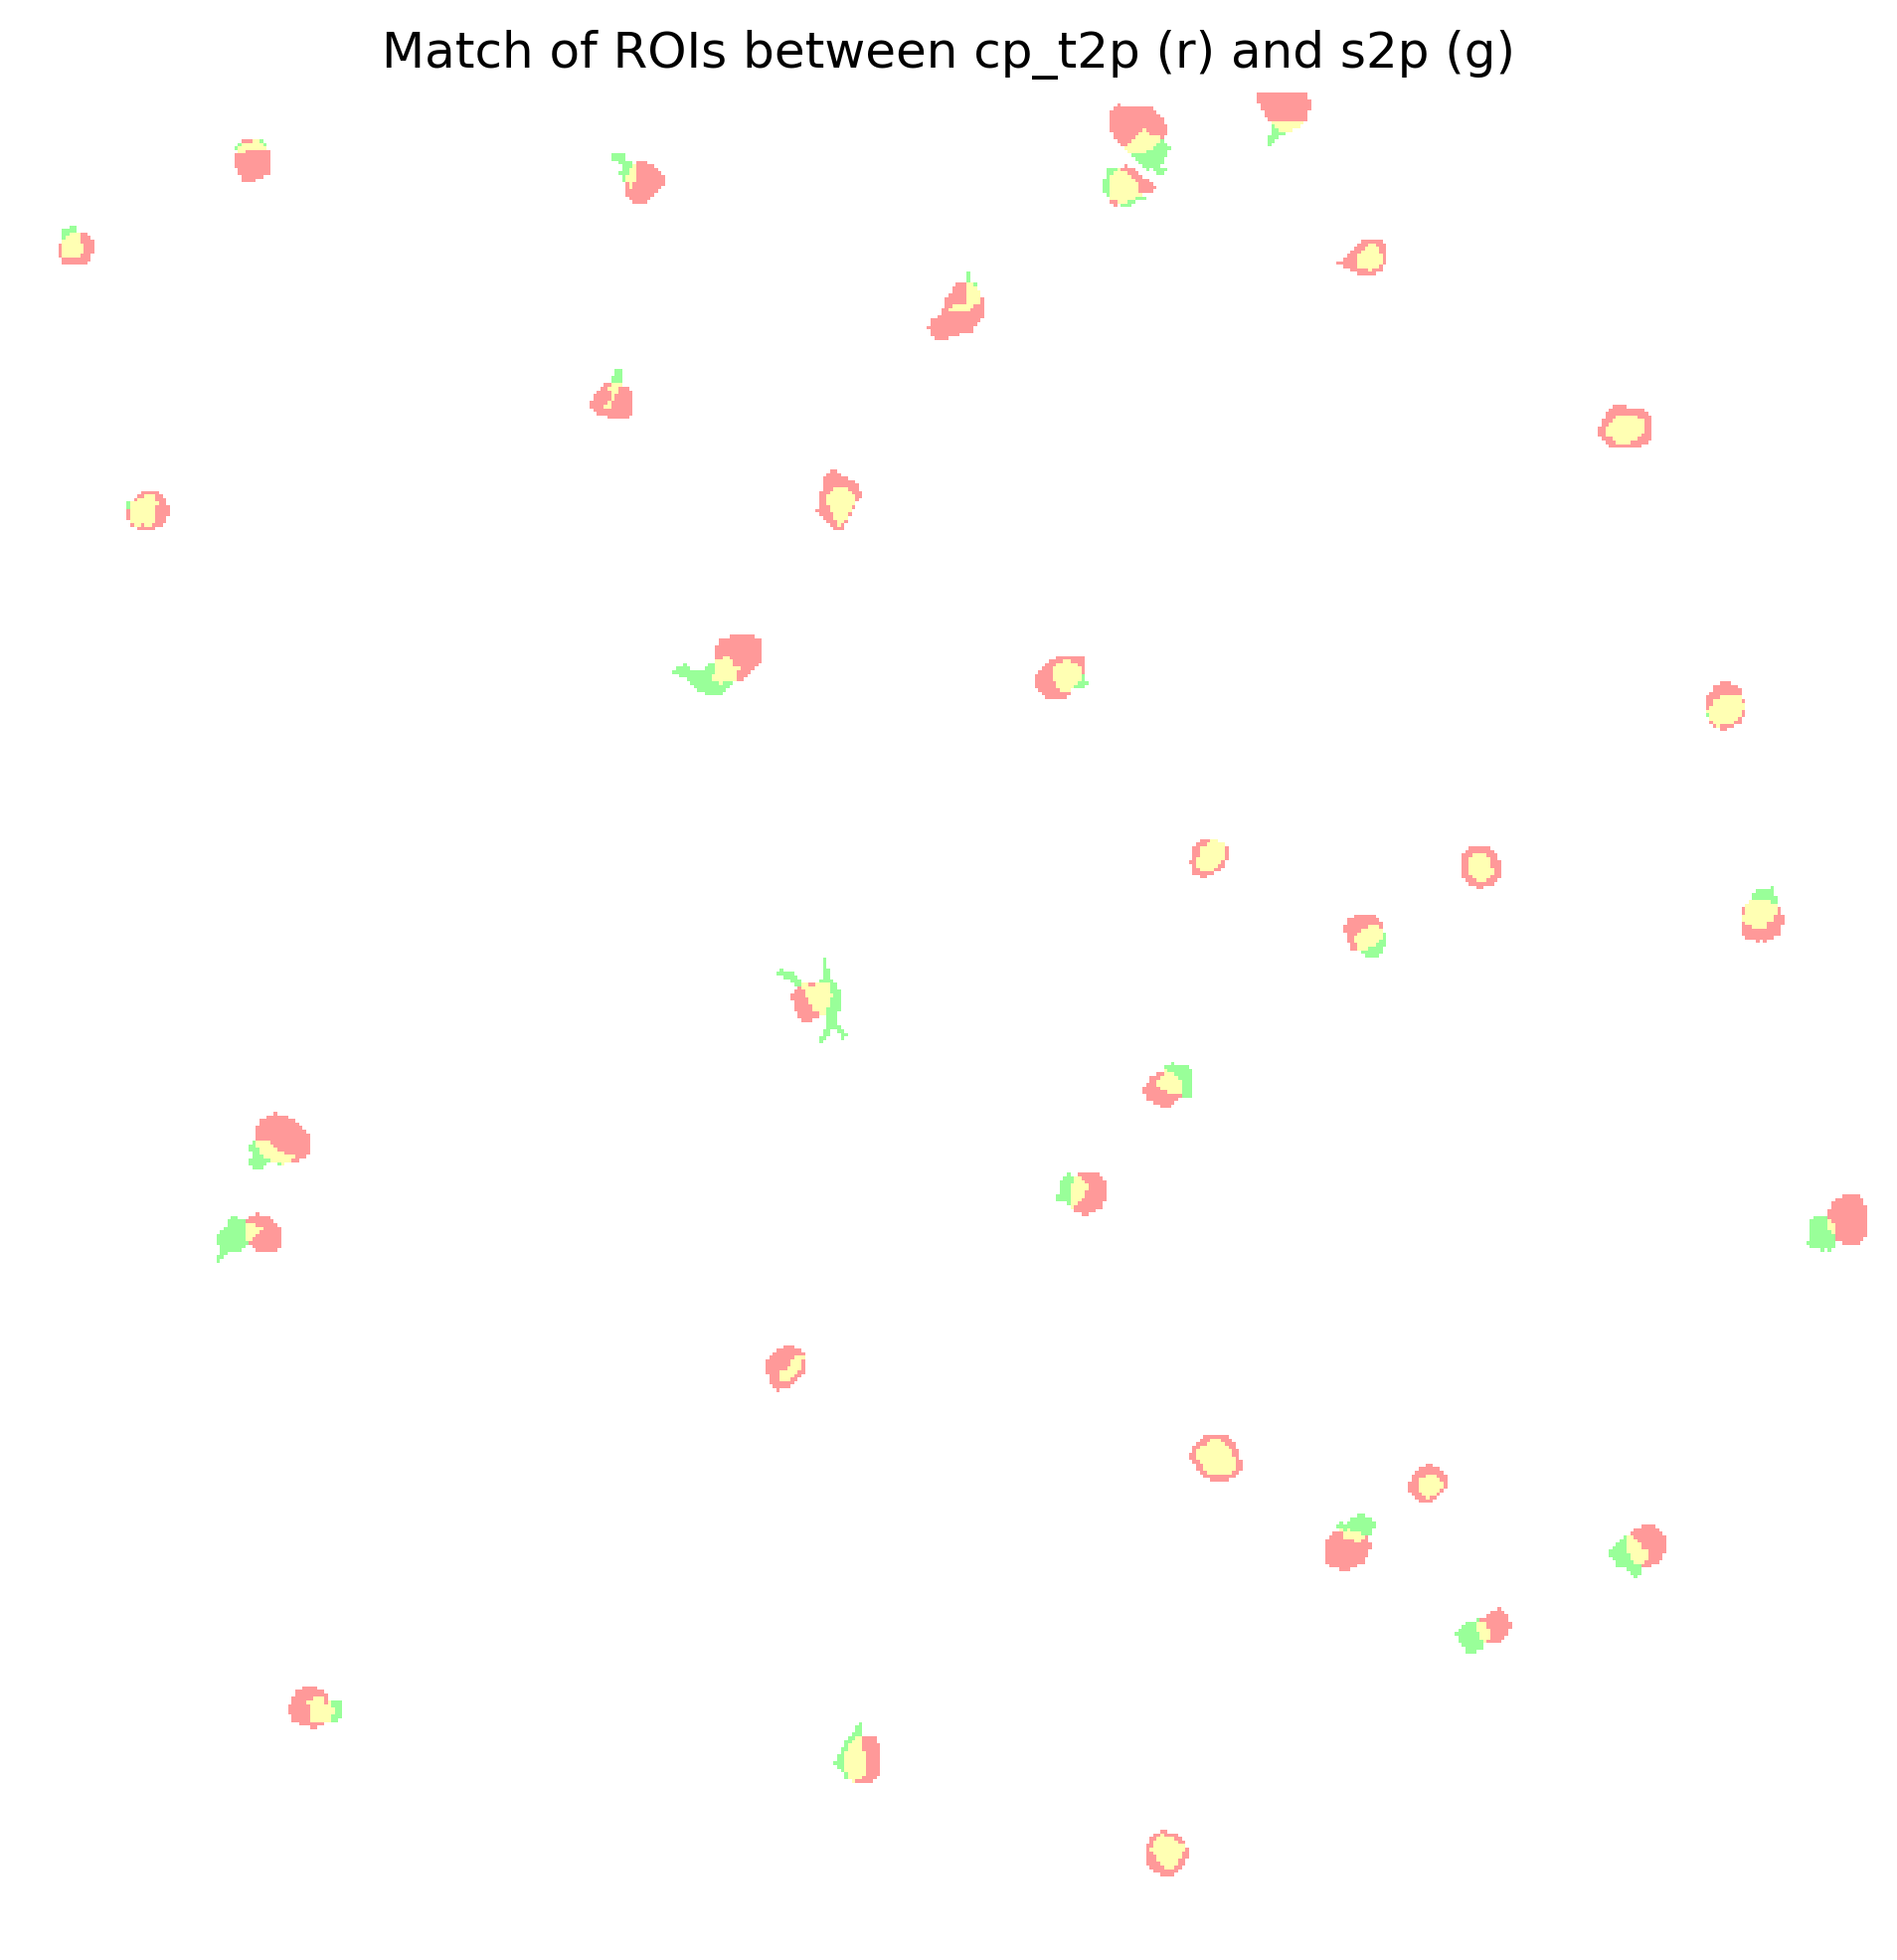

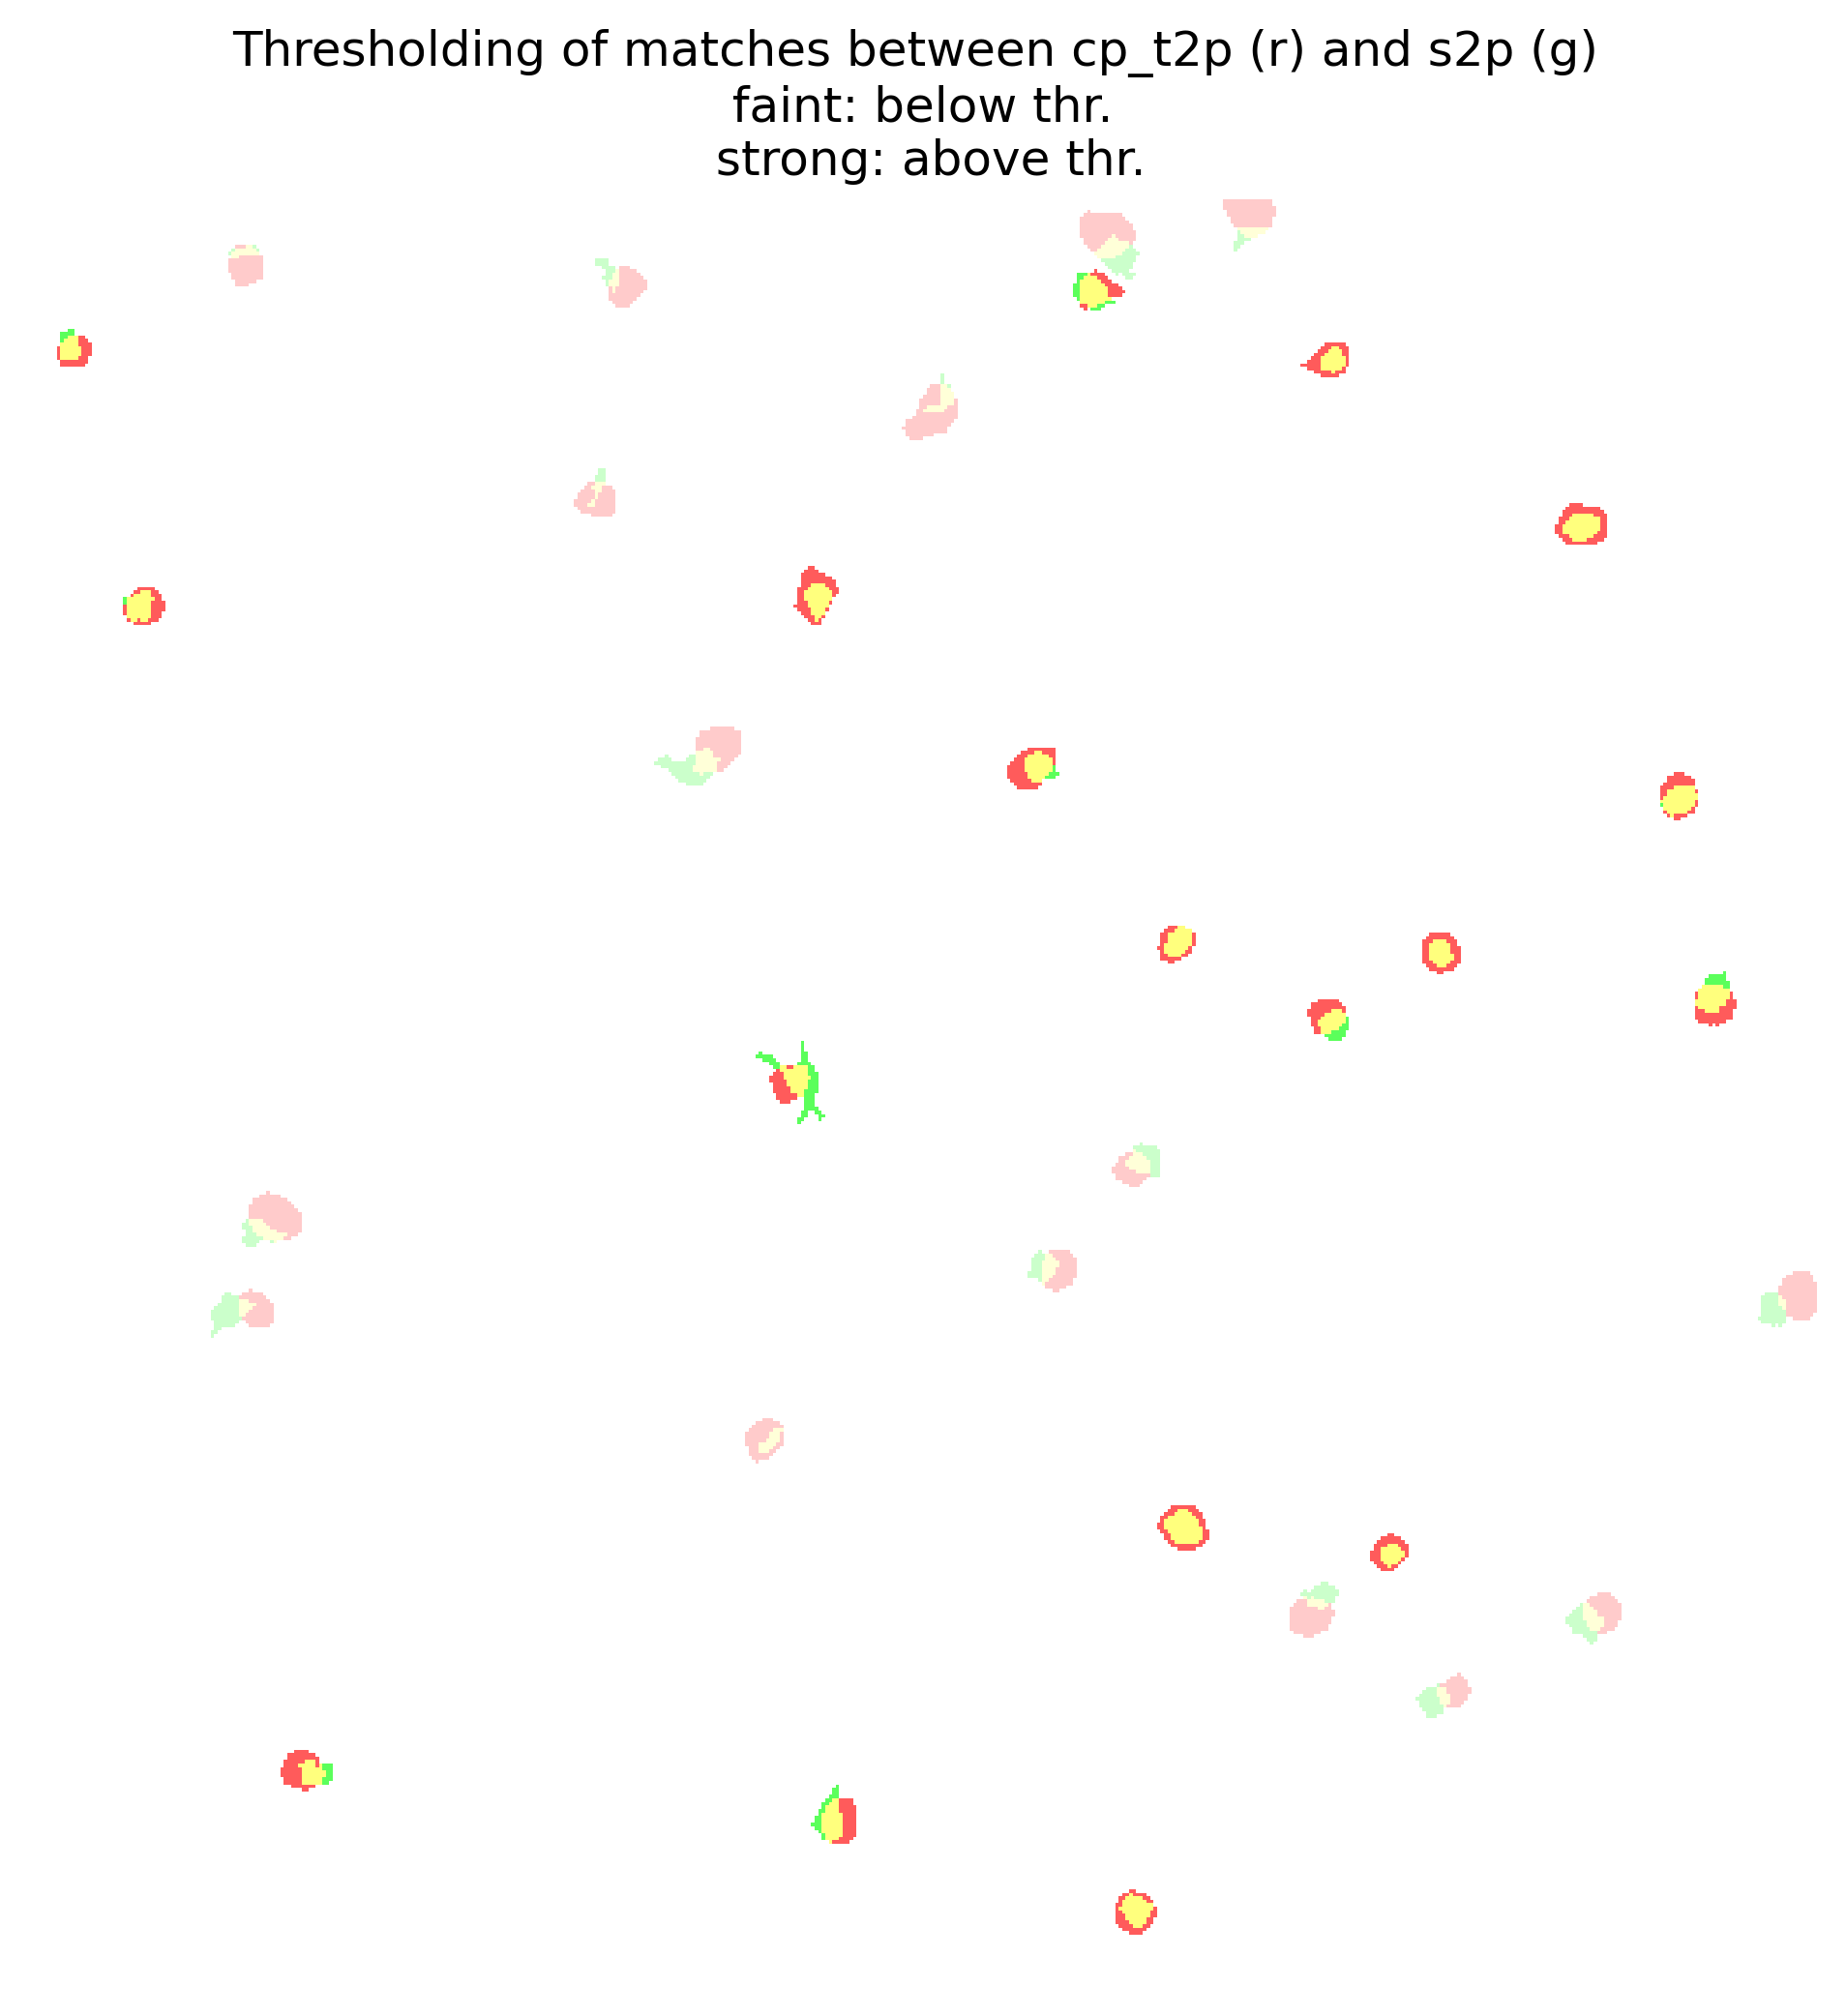

In [15]:
plot_iou_dist(thr_met, thr_otsu, thr_min)
plot_all_roi_overlay(roi_image_both, roi_image_both_matched, roi_image_both_matched_thr)

In [16]:
# now make a plot of the final matches and show which ones are above the threshold
all_ds_mean_img = load_all_ds_mean_img(track_ops_cp)
all_ds_mean_img_ch2 = load_all_ds_mean_img(track_ops_cp, ch=2)

# TODO: little images of the rois in the final match R G, correlation match, with contours and so on to show the final matches